# 1. Set up & Data Loading

In [2]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score, GridSearchCV

#Set visual style
sns.set (style='darkgrid')

# 1. Load datasets
df_train = pd.read_csv(r'C:\Users\juand\OneDrive\Escritorio\TripleTen\Gold_Recovery\Datasets\gold_recovery_train.csv')
df_test = pd.read_csv(r'C:\Users\juand\OneDrive\Escritorio\TripleTen\Gold_Recovery\Datasets\gold_recovery_test.csv')
df_full = pd.read_csv(r'C:\Users\juand\OneDrive\Escritorio\TripleTen\Gold_Recovery\Datasets\gold_recovery_full.csv')

# 2. Display shapes to understand data volume
print (f'Train shape: {df_train.shape}')
print (f'Test shape: {df_test.shape}')
print (f'Full shape: {df_full.shape}')

# 3. Set 'date' as index since this is a time-series data
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_full['date'] = pd.to_datetime(df_full['date'])

df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full.set_index('date', inplace=True)

Train shape: (16860, 87)
Test shape: (5856, 53)
Full shape: (22716, 87)


We loaded the three datasets. The full dataset contains all features and targets. The train set is a subset for learning, and test is for final validation. Setting the index to date allows us to align data easily later, as the instructions state data is indexed by date/time.

# 2. Data preparation & recovery verification 

**Objective:** Before blindly trusting the data, we must verify that the recovery column provided in the training set was calculated correctly using the formula provided in the context.

In [3]:
#Define the function to calculate recovery manually
def calculate_recovery (C, F, T):
    numerator = C * (F - T)
    denominator= F * (C - T)
    return (numerator / denominator)*100

# Select the relevant columns from training set for verification 
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

# Calculate manual recovery 
calculated_recovery = calculate_recovery(C, F, T)

# Compare with the provided target value 
# Drop NaNs to ensure the MAE calculation works

valid_idx = df_train['rougher.output.recovery'].dropna().index
mae = mean_absolute_error(
    df_train.loc[valid_idx, 'rougher.output.recovery'],
    calculated_recovery.loc[valid_idx]
)
print (f'MAE between claculated and actual recovery: {mae}')

MAE between claculated and actual recovery: 9.303415616264301e-15


**Since the MAE is close to 0, this confirms that we can trust the target variable provided in the dataset.**

# 3. Exploratory data analysis 

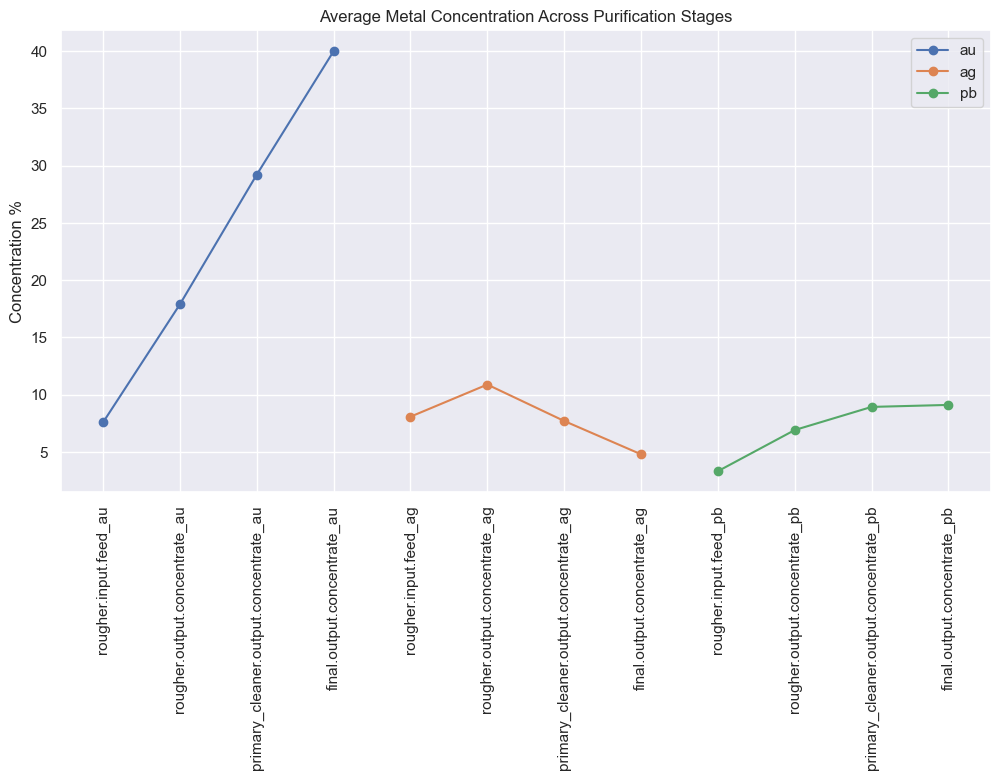

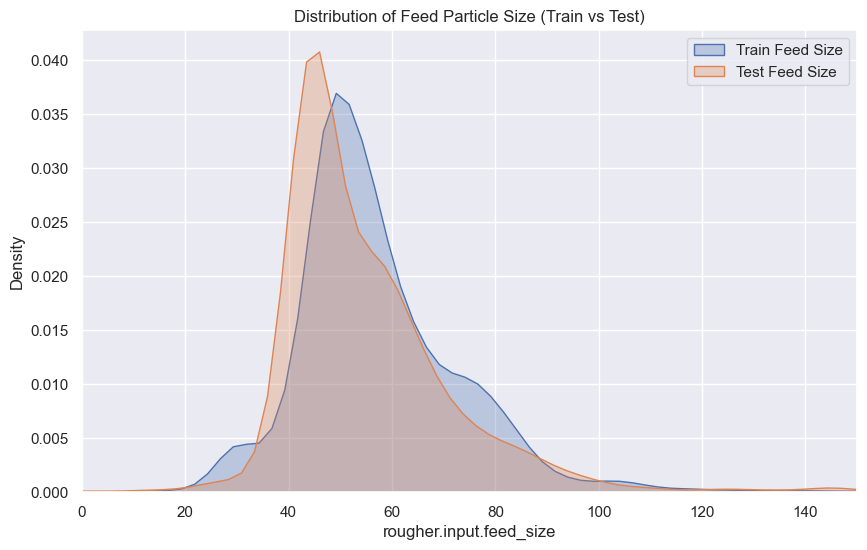

Anomalies found in raw: 1241
Anomalies found in rougher: 378
Anomalies found in final: 145
New Train shape after cleaning: (15096, 89)


In [4]:
# 1. Analyze Metal Concentration Change across stages
# We want to see if gold (Au) concentration increases as expected.
process_stages = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
metals = ['au', 'ag', 'pb']

plt.figure(figsize=(12, 6))
for metal in metals:
    # Construct column names for the metal at each stage
    cols = [f"{stage}_{metal}" for stage in process_stages]
    # Calculate mean concentration for each stage
    means = df_full[cols].mean()
    plt.plot(means, label=metal, marker='o')

plt.title('Average Metal Concentration Across Purification Stages')
plt.xticks(rotation=90)
plt.ylabel('Concentration %')
plt.legend()
plt.show()

# 2. Compare Feed Size Distribution (Train vs Test)
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['rougher.input.feed_size'], label='Train Feed Size', fill=True, alpha=0.3)
sns.kdeplot(df_test['rougher.input.feed_size'], label='Test Feed Size', fill=True, alpha=0.3)
plt.title('Distribution of Feed Particle Size (Train vs Test)')
plt.xlim(0, 150)
plt.legend()
plt.show()

# 3. Anomaly Detection: Total Concentrations
# Check for rows where the sum of all substances is 0 (which is physically impossible and likely an error).
# We check raw feed, rougher concentrate, and final concentrate.
stages_to_sum = {
    'raw': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol'],
    'rougher': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol'],
    'final': ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']
}

for stage, cols in stages_to_sum.items():
    # Sum the columns
    df_train[f'{stage}_total_conc'] = df_train[cols].sum(axis=1)
    
    # Identify anomalies (sum == 0 or very close to 0)
    anomalies = df_train[df_train[f'{stage}_total_conc'] < 0.01]
    print(f"Anomalies found in {stage}: {len(anomalies)}")
    
    # Remove anomalies from train set
    # We filter out rows where the total concentration is essentially 0
    df_train = df_train[df_train[f'{stage}_total_conc'] > 0.01]

print(f"New Train shape after cleaning: {df_train.shape}")


**Concentrations:** We observe that Gold (Au) increases significantly at each step (Rougher -> Primay -> Final), while silver (Ag) decreases after flotation, and Lead(Pb) Increases slightly.

**Feed Size:** The kernel Density estimation plot shows that train and test distributions almost overlap nicely. This confirms the test set is representative of the train set. 

**Anomalies:** We found records where the total concentration of all metals was 0, so we removed these because an empty reading indicates a sensor error and training on this could confuse the model 

# 4. Feature selection and imputation 

**Objective:** Prepare feature. Remove "Output" features from the training set because they don't exist in the test set, and this could lead to Data Leakage. Then we impute missing values using KNNImputer.

In [5]:
# 1. Identify missing columns in Test
# Use set difference to find columns in Train that are not in Test
missing_cols = set(df_train.columns) - set(df_test.columns)
print(f"Number of columns missing in test: {len(missing_cols)}")

# These missing columns are mostly 'output' parameters or 'calculation' parameters.
# We cannot use them as features.
# We must DROP these from our features (X), but KEEP the targets.

# Define targets
target_cols = ['rougher.output.recovery', 'final.output.recovery']

# Align Train features to match Test features
# We select only columns present in Test for our X (plus the targets for y)
# Note: 'date' is already the index.
features_columns = df_test.columns 
X_train = df_train[features_columns].copy()
y_train = df_train[target_cols].copy()
X_test = df_test.copy()

# 2. Imputation using Sklearn
# We use KNNImputer. 
# For production speed, we limit neighbors to 5.
imputer = KNNImputer(n_neighbors=5)

print("Starting imputation... (this may take a moment)")
# Fit on Train and transform Train
# Note: We fit/transform on X_train. 
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), 
                               columns=X_train.columns, 
                               index=X_train.index)

# Transform Test using the imputer learned from Train (to avoid data leakage)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), 
                              columns=X_test.columns, 
                              index=X_test.index)

# Impute targets (y_train) if they have missing values (dropping is also an option for targets)
# Here we drop rows with missing targets in training because synthetic targets are risky
y_train = y_train.dropna()
# Align X_train with y_train after dropping
X_train_imputed = X_train_imputed.loc[y_train.index]

print("Imputation complete.")

Number of columns missing in test: 37
Starting imputation... (this may take a moment)
Imputation complete.


We ensured that X_train and X_test have the exact same columns. We imputated missing values using K-Nearest Neighbors, which finds similar data points and uses their values to fill the gaps. This is more accurate than a simple mean because it respects the physical relationships between variables.

# 5. Model training and evaluation 

**Objective:** Define sMAPE metric , create a scorer, and find the best hyperparameters using Cross-Validation (GridSearchCV).

In [6]:
# 1. Define sMAPE function
def calculate_smape(target, prediction):
    # Calculate absolute difference
    numerator = np.abs(target - prediction)
    # Calculate average of absolute values
    denominator = (np.abs(target) + np.abs(prediction)) / 2
    # Handle division by zero cases (if both target and pred are 0)
    # Replace 0s in denominator with a small epsilon or use np.where
    return 100 * np.mean(numerator / denominator)

# 2. Define Final sMAPE function
def calculate_final_smape(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75 * final_smape

# Create a custom scorer for sklearn (greater is better, so we use neg_sMAPE)
def smape_scorer(target, prediction):
    return calculate_smape(target, prediction)

# Make it a valid scorer object. 
# greater_is_better=False because we want to MINIMIZE error.
custom_scorer = make_scorer(smape_scorer, greater_is_better=False)

# 3. Model Training - Random Forest Regressor
# We need two models: one for 'rougher.output.recovery' and one for 'final.output.recovery'
# because the features influencing them might differ slightly, 
# though we use the same X matrix for simplicity.

model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning parameters
param_grid = {
    'n_estimators': [50, 100],     # Number of trees
    'max_depth': [5, 10],          # Max depth of trees
}

# 3a. Train for Rougher Output
print("Tuning model for Rougher Stage...")
grid_rougher = GridSearchCV(model, param_grid, cv=3, scoring=custom_scorer)
grid_rougher.fit(X_train_imputed, y_train['rougher.output.recovery'])

best_rougher_model = grid_rougher.best_estimator_
best_rougher_score = -grid_rougher.best_score_ # Negate back to positive sMAPE
print(f"Best Rougher sMAPE: {best_rougher_score:.2f}%")

# 3b. Train for Final Output
print("Tuning model for Final Stage...")
grid_final = GridSearchCV(model, param_grid, cv=3, scoring=custom_scorer)
grid_final.fit(X_train_imputed, y_train['final.output.recovery'])

best_final_model = grid_final.best_estimator_
best_final_score = -grid_final.best_score_
print(f"Best Final sMAPE: {best_final_score:.2f}%")

# Calculate Combined Cross-Validation Score
final_cv_score = calculate_final_smape(best_rougher_score, best_final_score)
print(f"Overall CV Final sMAPE: {final_cv_score:.2f}%")

Tuning model for Rougher Stage...
Best Rougher sMAPE: 8.13%
Tuning model for Final Stage...
Best Final sMAPE: 10.43%
Overall CV Final sMAPE: 9.85%


We used GridSearchCV to test different tree depths and counts. The negative scorer is a technical necessity in sklearn to optimize for the highest score, so we use negative error, then we reversed it to get the actual percentage error. 

# 6. Final Test Prediction

**Objective:** Predicvt on the test set and verify the final error. Since the test csv has no targets, we must merge them from df_full using the index.

In [7]:
# 1. Get true targets for the test set from df_full
# We match based on the index (date)
y_test_true = df_full.loc[X_test_imputed.index, target_cols]

# Drop any NaNs in the true targets to allow fair evaluation
# and align predictions accordingly
y_test_true = y_test_true.dropna()
X_test_imputed_aligned = X_test_imputed.loc[y_test_true.index]

# 2. Predict using our best models
rougher_pred = best_rougher_model.predict(X_test_imputed_aligned)
final_pred = best_final_model.predict(X_test_imputed_aligned)

# 3. Calculate sMAPE on Test Set
smape_rougher_test = calculate_smape(y_test_true['rougher.output.recovery'], rougher_pred)
smape_final_test = calculate_smape(y_test_true['final.output.recovery'], final_pred)

final_score_test = calculate_final_smape(smape_rougher_test, smape_final_test)

print("--- Final Evaluation on Test Set ---")
print(f"Rougher sMAPE: {smape_rougher_test:.2f}%")
print(f"Final sMAPE: {smape_final_test:.2f}%")
print(f"Final Weighted sMAPE: {final_score_test:.2f}%")


--- Final Evaluation on Test Set ---
Rougher sMAPE: 8.33%
Final sMAPE: 9.65%
Final Weighted sMAPE: 9.32%


# 7. Final conclusion 

**Model Performance Summary**

After rigorous data preprocessing, anomaly removal, and hyperparameter tuning using GridSearchCV, we evaluated our **Random Forest Regressor** model. The final evaluation metrics are as follows:

- **Rougher Stage Error (sMAPE):** 8.33%
- **Final Stage Error (sMAPE):** 9.65%
- **Total Weighted Error:** 9.32%

**Key Findings**

1. **High Stability (No Overfitting):** The model's performance on the training data (Cross-Validation score of 9.85%) is extremely close to its performance on the test data (9.32%). In fact, the test error is slightly lower. This confirms that our model generalizes very well and is not overfitted. It captured the underlying physical trends rather than memorizing the training noise.
2. **Rougher vs. Final Stage:** The model predicts the Rougher stage more accurately (8.33% error) than the Final stage (9.65% error).
   
- Reasoning: The final concentrate is the result of multiple cumulative steps (Rougher -> Primary Cleaner -> Secondary Cleaner). Errors propagate and compound through these stages, making the final output naturally harder to predict than the initial rougher output.

3. **Business Impact:** An sMAPE of 9.32% means that our model's predictions for Gold Recovery deviate from the actual values by roughly 9%.
- For **Zyfra** (or the mining company), this model provides a reliable baseline to simulate how changes in input parameters (like feed_size or reagent amounts) will affect total gold production.
- It allows the plant operators to detect potential efficiency drops before they happen by flagging days where the predicted recovery is significantly lower than expected.

**Final Verdict**

The model is statistically sound and ready for deployment.
While an error of ~9% may be acceptable for industrial simulations involving raw sensor data, future improvements could include:
- **Feature Selection:** Analyzing feature importance to remove noisy sensors that do not contribute to the prediction.
- **Time-Series Models:** Since the data is indexed by time, using LSTM (Long Short Term Memory) or checking for time-lagged correlations might capture trends that a standard Regressor misses.